# 기계학습 - 2022년 2학기

## 과제2. 다중계층 신경망을 이용한 얼굴 표정 분류기 작성

과제 문의: 전북대학교 컴퓨터공학부 시각 및 학습 연구실 (공과대학 7호관 7619)

Requirements
- Python >= 3.6
- numpy
- matplotlib
- jupyterplot

이번 과제에서는 사람 얼굴의 표정 데이터셋(Toronto Faces Dataset, [TFD](http://aclab.ca/users/josh/TFD.html))을 분류하는 다중계층 신경망(Multi-Layer Neural Net)을 구현하고 테스트 합니다.

In [20]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

import importlib.util
try:
    importlib.util.find_spec('jupyterplot')
except ImportError:
    %pip install jupyterplot
    pass

from jupyterplot import ProgressPlot

try:
    importlib.util.find_spec('tqdm')
except ImportError:
    %pip install tqdm
    pass

### Toronto Faces Dataset


TFD는 1-Anger, 2-Disgust, 3-Fear, 4-Happy, 5-Sad, 6-Suprise, 7-Neutral의 총 7개의 클래스를 가진 데이터셋입니다.

데이터셋은 학습, 검증, 테스트(training, validation, test)를 위해서 각각 3374, 419, 385장의 48 $\times$ 48 크기 grayscale 이미지를 제공합니다.

데이터셋의 예시를 확인하기 위해 아래 셀들을 실행해보시기 바랍니다.

In [2]:
#### Please DO NOT DELETE this cell. ###

def LoadData(fname):
    """Loads data from an NPZ file.

    Args:
        fname: NPZ filename.

    Returns:
        data: Tuple {inputs, target}_{train, valid, test}.
              Row-major, outer axis to be the number of observations.
    """
    npzfile = np.load(fname)

    inputs_train = npzfile['inputs_train'].T / 255.0
    inputs_valid = npzfile['inputs_valid'].T / 255.0
    inputs_test = npzfile['inputs_test'].T / 255.0
    target_train = npzfile['target_train'].tolist()
    target_valid = npzfile['target_valid'].tolist()
    target_test = npzfile['target_test'].tolist()

    num_class = max(target_train + target_valid + target_test) + 1
    target_train_1hot = np.zeros([num_class, len(target_train)])
    target_valid_1hot = np.zeros([num_class, len(target_valid)])
    target_test_1hot = np.zeros([num_class, len(target_test)])

    for ii, xx in enumerate(target_train):
        target_train_1hot[xx, ii] = 1.0

    for ii, xx in enumerate(target_valid):
        target_valid_1hot[xx, ii] = 1.0

    for ii, xx in enumerate(target_test):
        target_test_1hot[xx, ii] = 1.0

    inputs_train = inputs_train.T
    inputs_valid = inputs_valid.T
    inputs_test = inputs_test.T
    target_train_1hot = target_train_1hot.T
    target_valid_1hot = target_valid_1hot.T
    target_test_1hot = target_test_1hot.T
    return inputs_train, inputs_valid, inputs_test, target_train_1hot, target_valid_1hot, target_test_1hot


training dataset
inputs: (3374, 2304) targets: (3374, 7)
validation dataset
inputs: (419, 2304) targets: (419, 7)
test dataset
inputs: (385, 2304) targets: (385, 7)


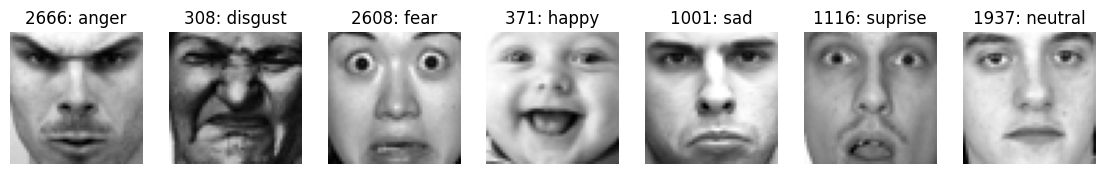

In [3]:
data = LoadData('./toronto_face.npz')
inputs = data[:3]
targets = data[3:]
inputs = {k:v for k, v in zip(['train', 'valid', 'test'], inputs)}
targets = {k:v for k, v in zip(['train', 'valid', 'test'], targets)}

print('training dataset')
print('inputs:', inputs['train'].shape, 'targets:', targets['train'].shape)
print('validation dataset')
print('inputs:', inputs['valid'].shape, 'targets:', targets['valid'].shape)
print('test dataset')
print('inputs:', inputs['test'].shape, 'targets:', targets['test'].shape)

classes = ['anger', 'disgust', 'fear', 'happy', 'sad', 'suprise', 'neutral']
_, labels = np.nonzero(targets['train'])

figs, axes = plt.subplots(nrows=1, ncols=7, figsize=(14,7))
for idx in range(7):
    axis = axes[idx]
    rnd_idx = np.random.choice(np.nonzero(labels == idx)[0])
    axis.axis('off')
    axis.imshow(inputs['train'][rnd_idx].reshape(48, 48), cmap='gray')
    axis.set_title('{}: {}'.format(rnd_idx, classes[idx]))
plt.show()

### Training Multi-layer Neural Networks


1. 기본적인 일반화 (basic generalization): 코드에 주어진 hyperparameter 들을 이용하여 신경망을 학습시킨다. 학습 오차(training error)와 일반화를 위한 검증 오차(validation error) 결과가 어떻게 다른지 설명한다. 두 가지 경우(학습과 일반화 검증)에 대해 오차 커브(error curve)를 그래프로 제시하시오.

2. 최적화 (optimization):  Learning rate, momentum, mini-batch size 세 가지 종류의 parameter 들을 아래와 같이 변화시키면서 다양한 조합들에 대해 신경망이 cross-entropy 관점에서 어떻게 수렴하는지 살펴본다. 가장 우수한 성능을 나타내는 hyperparameter 들의 조합이 어떤 것인지 제시하시오. (모든 경우의 수를 다 따지면 75 가지 신경망 모델을 테스트해야 하나 시간이 너무 많이 결릴 수 있으므로 이 중에서 일부분의 경우들만 테스트해도 된다. 그러나 어떤 근거로 해당 조합들만 테스트했는지 적당한 설명이 있어야 함.)
    - Learning rate ( $\epsilon$ ): 0.001 에서 1.0 사이의 5 가지 경우
    - Momentum: 0.0 에서 0.9 사이의 3 가지 경우
    - Mini-batch size: 1 에서 1000 까지의 5 가지 경우

3. 신경망 모델 구조 변경: Momentum 을 0.9로 고정시킨 상태에서 신경망의 hidden unit 들의 갯수를 2 에서 100 사이의 3 가지 다른 경우에 대해 성능을 비교한다. 필요한 경우 learning rate 와 학습 기간(epochs)은 신경망 구조에 따라 적당하게 변경할 수 있다. Hidden unit 의 갯수들이 학습에서의 수렴과 신경망의 일반화 성는에 미치는 영향에 대한 데이터(표나 그래프)를 제시하고 경향을 분석하시오.

## Method and Class Definitions for Neural Networks

### Utility methods

In [4]:
def Save(fname: str, data):
    """Saves the model to a numpy file."""
    print('Writing to ' + fname)
    np.savez_compressed(fname, **data)


def Load(fname: str):
    """Loads model from numpy file."""
    print('Loading from ' + fname)
    return dict(np.load(fname))

### Utility Classes

In [5]:
from dataclasses import dataclass, fields, asdict
from os import PathLike
from typing import List, Tuple, Dict, Any, Union, Optional, TextIO
import json


class BaseDataclass:
    def to_dict(self):
        return asdict(self)

    def to_json(self, fp: Union[str, PathLike, TextIO]):
        json.dump(self.to_dict(), fp, indent=2)

    @classmethod
    def from_dict(cls, d: Dict[str, Any]):
        return cls(**d)

    @classmethod
    def from_json_stream(cls, fp: TextIO):
        return cls.from_dict(json.load(fp))
    
    @classmethod
    def load_from_json(cls, fp_or_name: Union[str, PathLike, TextIO]):
        if isinstance(fp_or_name, str) or isinstance(fp_or_name, PathLike):
            with open(fp_or_name, 'r') as fp:
                return cls.from_json_stream(fp)
        else:
            return cls.from_json_stream(fp_or_name)
    
    def save_json(self, fp_or_name: Union[str, PathLike, TextIO]):
        if isinstance(fp_or_name, str) or isinstance(fp_or_name, PathLike):
            with open(fp_or_name, 'w') as fp:
                self.to_json(fp)
        else:
            self.to_json(fp_or_name)
    
    def keys(self):
        return [f.name for f in fields(self)]
    
    def values(self):
        return [getattr(self, f.name) for f in fields(self)]
    
    def items(self):
        return [(f.name, getattr(self, f.name)) for f in fields(self)]
    
    def copy(self):
        return self.from_dict(self.to_dict())

    def __getitem__(self, key):
        return getattr(self, key)

    def __setitem__(self, key, value):
        return setattr(self, key, value)

    def __iter__(self):
        return iter(self.keys())

@dataclass
class Config(BaseDataclass):
    """Configuration for the neural network."""
    num_inputs: int = 2304
    num_hiddens: Tuple[int,int] = (16, 8)
    num_outputs: int = 7
    eps: float = 1e-3
    momentum: float = 0.9
    num_epochs: int = 100
    batch_size: int = 128
    early_stopping: bool = True
    patience: int = 10

@dataclass
class ModelWeights(BaseDataclass):
    """Model for the neural network."""
    W1: np.ndarray
    b1: np.ndarray
    W2: np.ndarray
    b2: np.ndarray
    W3: np.ndarray
    b3: np.ndarray

    
    def to_json(cls, fp: Union[str, PathLike, TextIO]):
        raise NotImplementedError('Cannot save model weights to JSON.')
    
    def save_json(cls, fp_or_name: Union[str, PathLike, TextIO]):
        raise NotImplementedError('Cannot save model weights to JSON.')

    @classmethod
    def from_json_stream(cls, fp: TextIO):
        raise NotImplementedError('Cannot load model weights from JSON.')

    @classmethod
    def load_from_json(cls, fp_or_name: Union[str, PathLike, TextIO]):
        raise NotImplementedError('Cannot load model weights from JSON.')
    
    def copy(self):
        return ModelWeights(
            W1=self.W1.copy(),
            b1=self.b1.copy(),
            W2=self.W2.copy(),
            b2=self.b2.copy(),
            W3=self.W3.copy(),
            b3=self.b3.copy(),
        )

    def save(self, fp: Union[str, PathLike, TextIO]):
        """Saves the model to a numpy file."""
        np.savez_compressed(fp, **asdict(self))

    @classmethod
    def load(cls, fp: Union[str, PathLike, TextIO]):
        """Loads model from numpy file."""
        # Since the numpy version after 1.16.2, In response to CVE-2019-6446(https://nvd.nist.gov/vuln/detail/CVE-2019-6446),
        # np.savez_compressed allow_pickle=False by default.
        # In 1.16.2 and earlier, Arbitrary code execution can be performed by loading a maliciously crafted .npy file.
        # So, I set allow_pickle=False to prevent this vulnerability.
        data = dict(np.load(fp, allow_pickle=False))
        
        return cls(**data)

@dataclass
class Statistic(BaseDataclass):
    """Statistics for the neural network."""
    train_ce: List[Tuple[int, float]]
    valid_ce: List[Tuple[int, float]]
    train_acc: List[Tuple[int, float]]
    valid_acc: List[Tuple[int, float]]
    test_ce: float
    test_acc: float

    def keys(self):
        return [f.name for f in fields(self)]
    
    def __getitem__(self, key):
        return getattr(self, key)

    def best_valid_acc(self):
        return max(self.valid_acc, key=lambda x: x[1])

In [6]:
if False:
    import io
    # Test the dataclass
    # Config
    config = Config(2304, (100, 50), 7, 0.01, 0.9, 100, 100)
    fp = io.StringIO()
    config.save_json(fp)
    fp.seek(0)
    config = Config.load_from_json(fp)
    print(config)

    # ModelWeights
    model = ModelWeights(np.random.randn(2304, 100), np.random.randn(100), np.random.randn(100, 50), np.random.randn(50), np.random.randn(50, 7), np.random.randn(7))
    fp = io.BytesIO()
    model.save(fp)
    fp.seek(0)
    model = ModelWeights.load(fp)
    print(model.keys())
    
    # Statistic
    stat = Statistic([(1, 0.1), (2, 0.2)], [(1, 0.3), (2, 0.4)], [(1, 0.5), (2, 0.6)], [(1, 0.7), (2, 0.8)], 0.9, 1.0)
    fp = io.StringIO()
    stat.save_json(fp)
    fp.seek(0)
    stat = Statistic.load_from_json(fp)
    print(stat.keys())
    print(stat.best_valid_acc())


### Neural Networks
아래는 neural networks 의 초기화 및 forward pass를 구현한 코드 입니다.

In [7]:
def Affine(x: np.ndarray, w: np.ndarray, b: np.ndarray) -> np.ndarray:
    """Computes the affine transformation.

    Args:
        x: Inputs
        w: Weights
        b: Bias

    Returns:
        y: Outputs
    """
    # y = np.dot(w.T, x) + b
    y = x.dot(w) + b
    return y

def ReLU(x: np.ndarray) -> np.ndarray:
    """Computes the ReLU activation function.

    Args:
        x: Inputs

    Returns:
        y: Activation
    """
    return np.maximum(x, 0.0)

def Softmax(x: np.ndarray) -> np.ndarray:
    """Computes the softmax activation function.

    Args:
        x: Inputs

    Returns:
        y: Activation
    """
    x -= np.max(x, axis=1, keepdims=True)
    return np.exp(x) / np.exp(x).sum(axis=1, keepdims=True)

def InitMLP(num_inputs: int, num_hiddens: Tuple[int, int], num_outputs: int):
    """Initializes NN parameters.

    Args:
        num_inputs:    Number of input units.
        num_hiddens:   List of two elements, hidden size for each layer.
        num_outputs:   Number of output units.

    Returns:
        model:         Randomly initialized network weights.
    """
    W1 = 0.1 * np.random.randn(num_inputs, num_hiddens[0])
    W2 = 0.1 * np.random.randn(num_hiddens[0], num_hiddens[1])
    W3 = 0.01 * np.random.randn(num_hiddens[1], num_outputs)
    b1 = np.zeros((num_hiddens[0]))
    b2 = np.zeros((num_hiddens[1]))
    b3 = np.zeros((num_outputs))
    model = ModelWeights(W1, b1, W2, b2, W3, b3)
    return model

def NNForward(model: ModelWeights, x: np.ndarray) -> Dict[str, np.ndarray]:
    """Runs the forward pass.

    Args:
        model: Dictionary of all the weights.
        x:     Input to the network.

    Returns:
        var:   Dictionary of all intermediate variables.
    """
    h1 = Affine(x, model.W1, model.b1)
    h1r = ReLU(h1)
    h2 = Affine(h1r, model.W2, model.b2)
    h2r = ReLU(h2)
    y = Affine(h2r, model.W3, model.b3)
    var = {
        'x': x,
        'h1': h1,
        'h1r': h1r,
        'h2': h2,
        'h2r': h2r,
        'y': y
    }
    return var

아래는 neural networks 의 backward 구현하기 위한 코드들입니다.
아래 세 부분을 채워 코드를 완성시키기 바랍니다.

1. Affine layer 의 backward pass equations (linear trainsformation + bias).
2. RELU activation function 의 backward pass equations.
3. Momentum 이 포함된 weight update equations.

In [8]:
def AffineBackward(grad_y: np.ndarray, x: np.ndarray, w: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Computes gradients of affine transformation.

    Args:
        grad_y: gradient from last layer
        x: inputs
        w: weights

    Returns:
        grad_x: Gradients wrt. the inputs.
        grad_w: Gradients wrt. the weights.
        grad_b: Gradients wrt. the biases.
    """
    grad_x = grad_y.dot(w.T)
    grad_w = x.T.dot(grad_y)
    grad_b = np.sum(grad_y, axis=0)
    return grad_x, grad_w, grad_b

In [9]:
def ReLUBackward(grad_y: np.ndarray, x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """Computes gradients of the ReLU activation function.

    Returns:
        grad_x: Gradients wrt. the inputs.
    """
    grad_x = grad_y * (x > 0)
    return grad_x

In [10]:
def NNBackward(model: ModelWeights, err: np.ndarray, var: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
    """Runs the backward pass.

    Args:
        model:    Dictionary of all the weights.
        err:      Gradients to the output of the network.
        var:      Intermediate variables from the forward pass.
    Returns:
        grads:    Gradients to all the weights.
    """
    dE_dh2r, dE_dW3, dE_db3 = AffineBackward(err, var['h2r'], model['W3'])
    dE_dh2 = ReLUBackward(dE_dh2r, var['h2'], var['h2r'])
    dE_dh1r, dE_dW2, dE_db2 = AffineBackward(dE_dh2, var['h1r'], model['W2'])
    dE_dh1 = ReLUBackward(dE_dh1r, var['h1'], var['h1r'])
    _, dE_dW1, dE_db1 = AffineBackward(dE_dh1, var['x'], model['W1'])

    grads = {}
    grads['W1'] = dE_dW1
    grads['W2'] = dE_dW2
    grads['W3'] = dE_dW3
    grads['b1'] = dE_db1
    grads['b2'] = dE_db2
    grads['b3'] = dE_db3
    return grads

In [11]:
def InitMomentumState(model: ModelWeights) -> Dict[str, np.ndarray]:
    """Initializes momentums for all the weights.

    Args:
        model: Dictionary of all the weights.

    Returns:
        momentums: Dictionary of all the momentums.
    """
    momentums = {}
    for key in model.keys():
        momentums[key] = np.zeros_like(model[key])
    return momentums

def NNUpdate(model: ModelWeights, eps: float, momentum: float, optimizer_state: Dict[str, np.ndarray], grads: Dict[str, np.ndarray]):
    """Update NN weights.

    Args:
        model:    Dictionary of all the weights.
        eps:      Learning rate.
        momentum: Momentum.
        optimizer_state: State of the optimizer.
        tape:     Gradients to all the weights.
    """
    for key in model:
        # Momentum update
        # optimizer state is the velocity
        optimizer_state[key] = momentum * optimizer_state[key] - eps * grads[key]
        model[key] += optimizer_state[key]

### 훈련

In [12]:
def Train(model, forward, backward, update, eps, momentum, num_epochs,
          batch_size):
    """Trains a simple MLP.

    Args:
        model:           Dictionary of model weights.
        forward:         Forward prop function.
        backward:        Backward prop function.
        update:          Update weights function.
        eps:             Learning rate.
        momentum:        Momentum.
        num_epochs:      Number of epochs to run training for.
        batch_size:      Mini-batch size, -1 for full batch.

    Returns:
        stats:           Dictionary of training statistics.
            - train_ce:       Training cross entropy.
            - valid_ce:       Validation cross entropy.
            - train_acc:      Training accuracy.
            - valid_acc:      Validation accuracy.
    """
    inputs_train, inputs_valid, inputs_test, target_train, target_valid, \
        target_test = LoadData('./toronto_face.npz')
    rnd_idx = np.arange(inputs_train.shape[0])
    train_ce_list = []
    valid_ce_list = []
    train_acc_list = []
    valid_acc_list = []
    
    num_train_cases = inputs_train.shape[0]
    if batch_size == -1:
        batch_size = num_train_cases
    num_steps = int(np.ceil(num_train_cases / batch_size))

    pp = ProgressPlot(
        plot_names=['Cross entropy', 'Accuracy'],
        line_names=['Train', 'Validation'],
        x_label='Iteration',
        x_lim=[0, num_epochs*num_steps]
    )
    optimizer_state = InitMomentumState(model)

    valid_ce = 0
    valid_acc = 0
    for epoch in range(num_epochs):
        np.random.shuffle(rnd_idx)
        inputs_train = inputs_train[rnd_idx]
        target_train = target_train[rnd_idx]
        for step in range(num_steps):
            # Forward prop.
            start = step * batch_size
            end = min(num_train_cases, (step + 1) * batch_size)
            x = inputs_train[start: end]
            t = target_train[start: end]

            var = forward(model, x)
            prediction = Softmax(var['y'])

            train_ce = -np.sum(t * np.log(prediction)) / x.shape[0]
            train_acc = (np.argmax(prediction, axis=1) ==
                         np.argmax(t, axis=1)).astype('float').mean()
            pp.update([[train_ce, valid_ce], [train_acc, valid_acc]])

            # Compute error.
            error = (prediction - t) / x.shape[0]

            # Backward prop.
            grads = backward(model, error, var)

            # Update weights.
            update(model, eps, momentum, optimizer_state, grads)

        valid_ce, valid_acc = Evaluate(
            inputs_valid, target_valid, model, forward, batch_size=batch_size)
        
        pp.update([[train_ce, valid_ce], [train_acc, valid_acc]])
        train_ce_list.append((epoch, train_ce))
        train_acc_list.append((epoch, train_acc))
        valid_ce_list.append((epoch, valid_ce))
        valid_acc_list.append((epoch, valid_acc))

    # print()
    train_ce, train_acc = Evaluate(
        inputs_train, target_train, model, forward, batch_size=batch_size)
    valid_ce, valid_acc = Evaluate(
        inputs_valid, target_valid, model, forward, batch_size=batch_size)
    test_ce, test_acc = Evaluate(
        inputs_test, target_test, model, forward, batch_size=batch_size)
    print('CE: Train %.5f Validation %.5f Test %.5f' %
          (train_ce, valid_ce, test_ce))
    print('Acc: Train {:.5f} Validation {:.5f} Test {:.5f}'.format(
        train_acc, valid_acc, test_acc))
    pp.finalize()
    stats = {
        'train_ce': train_ce_list,
        'valid_ce': valid_ce_list,
        'train_acc': train_acc_list,
        'valid_acc': valid_acc_list
    }

    return model, stats

def Evaluate(inputs, target, model, forward, batch_size=-1):
    """Evaluates the model on inputs and target.

    Args:
        inputs: Inputs to the network.
        target: Target of the inputs.
        model:  Dictionary of network weights.
    """
    num_cases = inputs.shape[0]
    if batch_size == -1:
        batch_size = num_cases
    num_steps = int(np.ceil(num_cases / batch_size))
    ce = 0.0
    acc = 0.0
    for step in range(num_steps):
        start = step * batch_size
        end = min(num_cases, (step + 1) * batch_size)
        x = inputs[start: end]
        t = target[start: end]
        prediction = Softmax(forward(model, x)['y'])
        ce += -np.sum(t * np.log(prediction))
        acc += (np.argmax(prediction, axis=1) == np.argmax(
            t, axis=1)).astype('float').sum()
    ce /= num_cases
    acc /= num_cases
    return ce, acc

In [13]:
def CheckGrad(model, forward, backward, name, x):
    """Check the gradients

    Args:
        model: Dictionary of network weights.
        name: Weights name to check.
        x: Fake input.
    """
    np.random.seed(0)
    var = forward(model, x)
    loss = lambda y: 0.5 * (y ** 2).sum()
    grad_y = var['y']
    grads = backward(model, grad_y, var)
    grad_w = grads[name].ravel()
    w_ = model[name].ravel()
    eps = 1e-7
    grad_w_2 = np.zeros(w_.shape)
    check_elem = np.arange(w_.size)
    np.random.shuffle(check_elem)
    # Randomly check 20 elements.
    check_elem = check_elem[:20]
    for ii in check_elem:
        w_[ii] += eps
        err_plus = loss(forward(model, x)['y'])
        w_[ii] -= 2 * eps
        err_minus = loss(forward(model, x)['y'])
        w_[ii] += eps
        grad_w_2[ii] = (err_plus - err_minus) / 2 / eps
    np.testing.assert_almost_equal(grad_w[check_elem], grad_w_2[check_elem],
                                   decimal=3)


def main():
    """Trains a NN."""
    model_fname = 'nn_model.npz'
    stats_fname = 'nn_stats.npz'

    # Hyper-parameters. Modify them if needed.
    num_hiddens = [16, 32]
    eps = 0.01
    momentum = 0.0
    num_epochs = 1000
    batch_size = 100

    # Input-output dimensions.
    num_inputs = 2304
    num_outputs = 7

    # Initialize model.
    model = InitMLP(num_inputs, num_hiddens, num_outputs)

    # Uncomment to reload trained model here.
    # model = Load(model_fname)

    # Check gradient implementation.
    print('Checking gradients...')
    x = np.random.rand(10, 48 * 48) * 0.1
    CheckGrad(model, NNForward, NNBackward, 'W3', x)
    CheckGrad(model, NNForward, NNBackward, 'b3', x)
    CheckGrad(model, NNForward, NNBackward, 'W2', x)
    CheckGrad(model, NNForward, NNBackward, 'b2', x)
    CheckGrad(model, NNForward, NNBackward, 'W1', x)
    CheckGrad(model, NNForward, NNBackward, 'b1', x)
    print('Done.')
    # Train model.
    print('training...')
    trained_model, stats = Train(model, NNForward, NNBackward, NNUpdate, eps,
                  momentum, num_epochs, batch_size)

    plt.figure(0)
    plt.plot(np.array(stats['train_ce'])[:, 0], np.array(stats['train_ce'])[:, 1], 'b', label='Train')
    plt.plot(np.array(stats['valid_ce'])[:, 0], np.array(stats['valid_ce'])[:, 1], 'orange', label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Cross Entropy')
    plt.legend()

    plt.figure(1)
    plt.plot(np.array(stats['train_acc'])[:, 0], np.array(stats['train_acc'])[:, 1], 'b', label='Train')
    plt.plot(np.array(stats['valid_acc'])[:, 0], np.array(stats['valid_acc'])[:, 1], 'orange', label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    # Uncomment if you wish to save the model.
    Save(model_fname, model)

    # Uncomment if you wish to save the training statistics.
    Save(stats_fname, stats)

### Early Stopping 이 적용된 훈련

사양이 좋지 않은 컴퓨터에서 `ProgressPlot` 이 항목 수가 많아지면서(약 10000부터) 더 이상 그래프가 제대로 그리지 못하고 느려지는 있습니다. 이 문제는 `ProgressPlot`이 그래프를 그리는 것이 O(N)의 복잡도를 가져서 그렇습니다. 이를 해결하기 위해 `ProgressPlot`에서 `Tqdm` 으로 변경하였습니다. 

In [14]:
from tqdm import tqdm

def TrainAdvanced(model: ModelWeights, 
        forward=NNForward,
        backward=NNBackward,
        update=NNUpdate,
        eps = 0.01,
        momentum = 0.0,
        num_epochs = 1000,
        batch_size = 100,
        early_stopping: bool = True,
        patience: int = 10,
        verbose: bool = True,
        tqdm_leave: bool = True,
        pplot: bool = False,
        ) -> Tuple[ModelWeights, Statistic]:
    """Trains a simple MLP.

    Args:
        model:           Dictionary of model weights.
        forward:         Forward prop function.
        backward:        Backward prop function.
        update:          Update weights function.
        eps:             Learning rate.
        momentum:        Momentum.
        num_epochs:      Number of epochs to run training for.
        batch_size:      Mini-batch size, -1 for full batch.
        early_stopping:  Whether to use early stopping.
        patience:        Number of epochs to wait before early stopping.
        verbose:         Whether to print training statistics.
        tqdm_leave:      Whether to leave tqdm progress bar.
        pplot:           Whether to plot training statistics.

    Returns:
        model:           Trained model.
        stats:           Dictionary of training statistics.
            - train_ce:       Training cross entropy.
            - valid_ce:       Validation cross entropy.
            - train_acc:      Training accuracy.
            - valid_acc:      Validation accuracy.
    """
    # load data
    inputs_train, inputs_valid, inputs_test, target_train, target_valid, \
        target_test = LoadData('./toronto_face.npz')
    
    rnd_idx = np.arange(inputs_train.shape[0])
    train_ce_list = []
    valid_ce_list = []
    train_acc_list = []
    valid_acc_list = []
    
    num_train_cases = inputs_train.shape[0]
    if batch_size == -1 or batch_size > num_train_cases or batch_size == 0:
        batch_size = num_train_cases
    num_steps = int(np.ceil(num_train_cases / batch_size))

    try:
        if pplot:
            # initialize plot
            pp = ProgressPlot(
                plot_names=['Cross entropy', 'Accuracy'],
                line_names=['Train', 'Validation'],
                x_label='Iteration',
                x_lim=[0, num_epochs]
            )
            pbar = range(num_epochs)
        else:
            # Tqdm progress bar.
            pbar = tqdm(range(num_epochs), disable=not verbose or num_epochs == 1, leave=tqdm_leave)

        # Initialize optimizer state
        optimizer_state = InitMomentumState(model)

        # Initialize stats.
        valid_ce = 0
        valid_acc = 0

        # Early stopping
        best_valid_ce = np.inf
        best_valid_acc = 0
        best_epoch = 0
        best_model = None

        epsilon = np.finfo(float).eps

        for epoch in pbar:
            np.random.shuffle(rnd_idx)
            inputs_train = inputs_train[rnd_idx]
            target_train = target_train[rnd_idx]

            train_ce = 0
            train_acc = 0
            for step in range(num_steps):
                # Get mini-batch.
                start = step * batch_size
                # min is used to handle the case when batch_size does not divide num_train_cases
                end = min(num_train_cases, (step + 1) * batch_size)

                input_batch = inputs_train[start: end]
                target_batch = target_train[start: end]

                # Forward prop.
                var = forward(model, input_batch)
                prediction = Softmax(var['y'])

                # Compute loss.
                train_ce += -np.sum(target_batch * np.log(prediction + epsilon)) / input_batch.shape[0]
                train_acc += (np.argmax(prediction, axis=1) ==
                             np.argmax(target_batch, axis=1)).astype('float').sum()

                # Compute error.
                error = (prediction - target_batch) / input_batch.shape[0]

                # Backward prop.
                grads = backward(model, error, var)

                # Update weights.
                update(model, eps, momentum, optimizer_state, grads)

            train_ce /= num_steps
            train_acc /= num_train_cases

            # Compute validation error.
            valid_ce, valid_acc = Evaluate(
                inputs_valid, target_valid, model, forward, batch_size=batch_size)

            train_ce_list.append((epoch, train_ce))
            train_acc_list.append((epoch, train_acc))
            valid_ce_list.append((epoch, valid_ce))
            valid_acc_list.append((epoch, valid_acc))

            if pplot:
                # Update plot.
                pp.update([[train_ce, valid_ce], [train_acc, valid_acc]])
            else:
                # Tqdm progress bar.
                pbar.set_description(f"Train CE: {train_ce:.4f}, Valid CE: {valid_ce:.4f}, Train Acc: {train_acc:.4f}, Valid Acc: {valid_acc:.4f}")

            # Early stopping.
            if valid_ce < best_valid_ce:
                    best_valid_ce = valid_ce
                    best_valid_acc = valid_acc
                    best_epoch = epoch
                    best_model = model.copy()
            elif early_stopping and epoch - best_epoch >= patience:
                    model = best_model
                    break
                
        test_ce, test_acc = Evaluate(
            inputs_test, target_test, model, forward, batch_size=batch_size)

        stats = Statistic(train_ce_list, valid_ce_list, train_acc_list, valid_acc_list,
            test_ce=test_ce, test_acc=test_acc)
    finally:
        if not pplot:
            pbar.close()
        else:
            pp.finalize()
    
    return model, stats

In [15]:
def TrainMLP(conf: Config, pplot: bool = False) -> Tuple[ModelWeights, Statistic]:
    """Trains a simple MLP.

    Args:
        conf: Configuration.
        pplot: Whether to plot training statistics.

    Returns:
        model: Trained model.
        stats: Dictionary of training statistics.
            - train_ce:       Training cross entropy list.
            - valid_ce:       Validation cross entropy list.
            - train_acc:      Training accuracy list.
            - valid_acc:      Validation accuracy list.
            - test_ce:        Test cross entropy.
            - test_acc:       Test accuracy.
    """
    # Initialize model.
    model = InitMLP(
        conf.num_inputs, conf.num_hiddens, conf.num_outputs)

    # Train model.
    model, stats = TrainAdvanced(
        model,
        eps=conf.eps,
        momentum=conf.momentum,
        num_epochs=conf.num_epochs,
        batch_size=conf.batch_size,
        early_stopping=conf.early_stopping,
        patience=conf.patience,
        verbose=True,
        tqdm_leave=False,
        pplot=pplot)

    return model, stats

In [16]:
def PlotStats(stats: Statistic, title: str = '', save_path: Optional[str] = None, show: bool = True):
    """Plots training statistics.

    Args:
        stats: Dictionary of training statistics.
            - train_ce:       Training cross entropy list.
            - valid_ce:       Validation cross entropy list.
            - train_acc:      Training accuracy list.
            - valid_acc:      Validation accuracy list.
            - test_ce:        Test cross entropy.
            - test_acc:       Test accuracy.
        title: Plot title.
    """
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(title)
    ax[0].set_title('Cross Entropy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Cross Entropy')
    ax[0].plot(*zip(*stats.train_ce), label='Train')
    ax[0].plot(*zip(*stats.valid_ce), label='Valid')
    ax[0].legend()
    ax[1].set_title('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].plot(*zip(*stats.train_acc), label='Train')
    ax[1].plot(*zip(*stats.valid_acc), label='Valid')
    ax[1].legend()
    if save_path is not None:
        plt.savefig(save_path)
    if show:
        plt.show()
    # close the plot
    plt.close()

In [17]:
# Test PlotStats.
if False:
    mock_stats = Statistic(
        train_ce=[(0, 0.5), (1, 0.4), (2, 0.3)],
        valid_ce=[(0, 0.6), (1, 0.5), (2, 0.4)],
        train_acc=[(0, 0.7), (1, 0.8), (2, 0.9)],
        valid_acc=[(0, 0.6), (1, 0.5), (2, 0.4)],
        test_ce=0.3,
        test_acc=0.9,
    )
    PlotStats(mock_stats, title='MLP')

In [18]:
import os

def ExperimentMLP(conf: Config, title: Optional[str] = None, save_dir: Union[str, PathLike] = 'results', show: bool = True, pplot: bool = False):
    """Runs a simple MLP experiment.

    Args:
        conf: Configuration.
        save_dir: Directory to save results.
        show: Whether to show plots.
    """
    if title is None:
        title = f'MLP [{",".join([str(s) for s in conf.num_hiddens])}] lr:{conf.eps} m:{conf.momentum} b:{conf.batch_size}'
    # Create save directory.
    os.makedirs(save_dir, exist_ok=True)

    # Train model.
    model, stats = TrainMLP(conf, pplot=pplot)
    conf.save_json(os.path.join(save_dir, 'conf.json'))
    model.save(os.path.join(save_dir, 'model.npz'))
    # Plot training statistics.
    PlotStats(stats, title='MLP', save_path=os.path.join(save_dir, 'stats.png'), show=show)
    stats.save_json(os.path.join(save_dir, 'stats.json'))

    return model, stats

In [24]:
if False:
    import traceback
    import time
    try:
        begin = time.time()
        # Test ExperimentMLP.
        ExperimentMLP(Config(), save_dir='test_mlp', show=True)
        end = time.time()
        print(f"Time: {end - begin:.2f} seconds")
    except TypeError as e:
        print('TypeError: ', e)
        traceback.print_exc()

### 테스트

In [21]:
def load_experiment(path: Union[str, PathLike], load_model = False) -> Tuple[Config ,Statistic, Optional[ModelWeights]]:
    """Loads experiment result

    Args:
        path: Path to experiment directory.
        load_model: Whether to load model.

    Returns:
        conf: Configuration.
        stats: Dictionary of training statistics.
            - train_ce:       Training cross entropy list.
            - valid_ce:       Validation cross entropy list.
            - train_acc:      Training accuracy list.
            - valid_acc:      Validation accuracy list.
            - test_ce:        Test cross entropy.
            - test_acc:       Test accuracy.
        model: Trained model.
    """
    stat = Statistic.load_from_json(os.path.join(path, 'stats.json'))
    conf = Config.load_from_json(os.path.join(path, 'conf.json'))
    model = None
    if load_model:
        model = ModelWeights.load(os.path.join(path, 'model.npz'))
    return conf, stat, model

In [26]:
if False:
    if not os.path.exists('test_mlp'):
        ExperimentMLP(Config(), save_dir='test_mlp', show=True)
    conf, stats, model = load_experiment('test_mlp', load_model=True)
    print(conf)
    print(stats)
    print(model)


In [95]:
def load_experiment_metafile(path: PathLike, init_task_if_not_exists: Optional[List[Any]] = None) -> Dict[str, List[Any]]:
    """Load meta data of all experiments
    
    Args:
        path: Path to meta file.
        init_task_if_not_exists: Initialize meta file if not exists.

    Returns:
        meta: Dictionary of meta data.
    """
    # load previous experiments if any exist
    try:
        with open(path, 'r') as f:
            experiments = json.load(f)
    except FileNotFoundError:
        experiments = {
            "remain_experiments": [],
            "completed_experiment_results": [] # list of completed experiment
        }
        if init_task_if_not_exists is not None:
            experiments["remain_experiments"] = init_task_if_not_exists.copy() # list of remaining experiment
    return experiments

def save_experiment_metafile(path: PathLike, experiments: Dict[str, Any]):
    """Save meta data of all experiments
    
    Args:
        path: Path to meta file.
        experiments: Dictionary of meta data.    
    """
    with open(path, 'w') as f:
        json.dump(experiments, f, indent=4)

## 문제

### 1. 기본적인 일반화 (basic generalization): 코드에 주어진 hyperparameter 들을 이용하여 신경망을 학습시킨다. 학습 오차(training error)와 일반화를 위한 검증 오차(validation error) 결과가 어떻게 다른지 설명한다. 두 가지 경우(학습과 일반화 검증)에 대해 오차 커브(error curve)를 그래프로 제시하시오.

In [121]:
main()

Checking gradients...
Done.
training...


<IPython.core.display.Javascript object>

KeyboardInterrupt: 

학습 오차(training error)와 일반화를 위한 검증 오차(validation error) 결과는 다음과 같습니다.

```
CE: Train 0.25610 Validation 0.97890 Test 0.78023
Acc: Train 0.90486 Validation 0.73986 Test 0.77143
```

그래프는 다음과 같습니다.

![loss_graph](./defaultLossGraph.png)
![accuracy_graph](./defaultAccuracyGraph.png)

학습 오차가 크게 감소하고 일반화 검증 오차는 점점 증가하는 것을 확인할 수 있습니다.

### 2. 최적화 (optimization):  Learning rate, momentum, mini-batch size 세 가지 종류의 parameter 들을 아래와 같이 변화시키면서 다양한 조합들에 대해 신경망이 cross-entropy 관점에서 어떻게 수렴하는지 살펴본다. 가장 우수한 성능을 나타내는 hyperparameter 들의 조합이 어떤 것인지 제시하시오. (모든 경우의 수를 다 따지면 75 가지 신경망 모델을 테스트해야 하나 시간이 너무 많이 결릴 수 있으므로 이 중에서 일부분의 경우들만 테스트해도 된다. 그러나 어떤 근거로 해당 조합들만 테스트했는지 적당한 설명이 있어야 함.)
    - Learning rate ( $\epsilon$ ): 0.001 에서 1.0 사이의 5 가지 경우
    - Momentum: 0.0 에서 0.9 사이의 3 가지 경우
    - Mini-batch size: 1 에서 1000 까지의 5 가지 경우


#### 실험 코드

In [19]:
import itertools
# 3374 can be factorized into 2 * 7 * 241
factor = set([1, 2, 7, 241])
# make all the multiplication of combinations of factors
combinations = [set(np.prod(x) for x in itertools.combinations(factor, i)) for i in range(1, len(factor)+1)]
combinations = set.union(*combinations)
combinations

{1, 2, 7, 14, 241, 482, 1687, 3374}


나머지가 없는 Mini-batch size는 1, 2, 7, 14, 241, 482, 1687, 3374 입니다.

In [165]:
[1000**(i/5) for i in range(1, 6)]

[3.9810717055349727,
 15.848931924611136,
 63.095734448019314,
 251.1886431509581,
 1000.0]

1000을 배수단위로 5등분을 하면 3.98, 15.84, 63.09, 251.18, 1000 이 됩니다.

In [203]:
# pick top 10
center, width = 63, 15
cand = [(i,3374 % i, (i - 3374 % i) / i) for i in range(center-(width//2), center+(width//2))]
cand = sorted(cand, key=lambda x: x[2])
cand[:10]

[(65, 59, 0.09230769230769231),
 (69, 62, 0.10144927536231885),
 (64, 46, 0.28125),
 (68, 42, 0.38235294117647056),
 (63, 35, 0.4444444444444444),
 (62, 26, 0.5806451612903226),
 (67, 24, 0.6417910447761194),
 (61, 19, 0.6885245901639344),
 (56, 14, 0.75),
 (60, 14, 0.7666666666666667)]

그래서 2, 14, 65, 241, 844를 선택하였습니다.

In [20]:
conf = Config(
    num_inputs=2304,
    num_hiddens=[16, 32],
    num_outputs=7,
    eps=0.5,
    momentum=0.0,
    num_epochs=1000,
    batch_size=844,
    early_stopping=True,
    patience=100,
)
_, stat = ExperimentMLP(conf, save_dir='results/example_lr=0.5', show=True, pplot=True)
print(f"Test accuracy: {stat.test_acc:.4f}, Test cross entropy: {stat.test_ce:.4f}")
print("Done")

TypeError: ExperimentMLP() missing 1 required positional argument: 'title'

위 셀에서 lr을 변경해서 나올 수 있는 결과는 다음과 같습니다.

![lr1.0plot](./lr1plot.png)

> lr 1.0 plot
 
![lr0.5plot](./lr0.5plot.png)

> lr 0.5 plot 

다음 그래프를 보면 알 수 있듯 배치를 아무리 높여도 lr = 0.5 일때 최적화가 잘 될 수 없다고 판단 하였습니다. 그래서 제외하였습니다. 1.0도 마찬가지이므로 제외하였습니다.

In [29]:
conf = Config(
    num_inputs=2304,
    num_hiddens=[16, 32],
    num_outputs=7,
    eps=0.01,
    momentum=0.0,
    num_epochs=1000,
    batch_size=100,
    early_stopping=True,
    patience=50,
)

# Grid search for hyperparameters.
lr_candidates = [0.1, 0.05, 0.01, 0.005, 0.001]
momentum_candidates = [0.0, 0.5, 0.9]
mini_batch_size_candidates = [2, 14, 65, 241, 844]

# Make all combinations of hyperparameters.
import itertools

experiments_list = [*itertools.product(lr_candidates, momentum_candidates, mini_batch_size_candidates)]

In [32]:
import time

experiments = load_experiment_metafile('experiments.json', 
    init_task_if_not_exists=experiments_list)

if len(experiments["remain_experiments"]) == 0:
    print("All experiments completed")

# Run experiments.
# tqdm nested progress bar is not working in my jupyter notebook
# so I just print the progress
while len(experiments['remain_experiments']) > 0:
    # get next experiment
    lr, momentum, mini_batch_size = experiments['remain_experiments'].pop(0)
    # set experiment directory
    save_dir = f"results/lr={lr}_momentum={momentum}_batch_size={mini_batch_size}"
    # create experiment config
    conf.eps = lr
    conf.momentum = momentum
    conf.batch_size = mini_batch_size
    # print experiment parameters
    print(f"Experiment: lr={lr}, momentum={momentum}, batch_size={mini_batch_size}")
    
    start = time.time()
    # run experiment
    ExperimentMLP(conf, save_dir=save_dir, show=False)
    
    end = time.time()
    # add experiment to completed experiments
    experiments['completed_experiment_results'].append({
        "lr": lr,
        "momentum": momentum,
        "mini_batch_size": mini_batch_size,
        "save_dir": save_dir,
        "time": end - start
    })
    # print completed experiments , remaining experiments and time taken
    print("\n".join([f"Completed experiments: {len(experiments['completed_experiment_results'])}",
                     f"Remaining experiments: {len(experiments['remain_experiments'])}",
                     f"Time taken: {end - start:.2f} seconds"]))
    # save experiments
    save_experiment_metafile('experiments.json', experiments)

All experiments completed


위의 셀들를 실행하면 실험을 진행할 수 있습니다.

In [96]:
from tqdm import tqdm
def get_lbm_experiment_results(experiments: Dict[str, Any], use_tqdm: bool = False):
    """Get experiment results from meta data"""
    experiments_results = experiments['completed_experiment_results']
    if use_tqdm:
        experiments_results = tqdm(experiments_results)
    results = []
    for experiment in experiments_results:
        # load experiment statistics
        _, stat, _ = load_experiment(experiment['save_dir'], load_model=False)
        i, best_valid_acc = stat.best_valid_acc()
        # add experiment parameters and statistics to results
        results.append({
            "lr": experiment['lr'],
            "momentum": experiment['momentum'],
            "mini_batch_size": experiment['mini_batch_size'],
            "test_acc": stat.test_acc,
            "test_ce": stat.test_ce,
            "train_acc": stat.train_acc[i][1],
            "train_ce": stat.train_ce[i][1],
            "valid_acc": best_valid_acc,
            "valid_ce": stat.valid_ce[i][1],
            "time": experiment['time']
        })
    return results

#### 결과

In [97]:
# load experiments
experiments = load_experiment_metafile('experiments.json')
# get experiment results
results = get_lbm_experiment_results(experiments, use_tqdm=True)

100%|██████████| 75/75 [00:00<00:00, 612.94it/s]


In [88]:
from IPython.display import display, HTML, Markdown

for m in momentum_candidates:
    markdown_table_content = []
    markdown_table_content.append("|  |" + "|".join(map(str, lr_candidates)) + "|")
    markdown_table_content.append("|" + "|".join(["---"] * (len(lr_candidates) + 1)) + "|")
    for batch in mini_batch_size_candidates:
        inner_content = []
        markdown_table_content.append("|" + str(batch) + "|")
        for lr in lr_candidates:
            # filter results
            filtered_results = [result for result in results if result['lr'] == lr and result['momentum'] == m and result['mini_batch_size'] == batch]
            if len(filtered_results) == 1:
                result = filtered_results[0]
            inner_content.append(f"{result['valid_acc'] * 100:.2f}")
        markdown_table_content[-1] += "|".join(inner_content) + "|"
    display(Markdown(f"#### Momentum = {m}\n" + "\n".join(markdown_table_content)))
    # print(f"#### Momentum = {m}\n"+"\n".join(markdown_table_content))
                

#### Momentum = 0.0
|  |0.1|0.05|0.01|0.005|0.001|
|---|---|---|---|---|---|
|2|28.16|44.87|75.18|76.37|75.42|
|14|71.12|74.22|77.57|76.37|72.32|
|65|74.46|76.61|74.46|74.70|66.11|
|241|65.16|73.27|73.51|66.83|47.26|
|844|50.60|68.97|63.48|55.61|28.16|

#### Momentum = 0.5
|  |0.1|0.05|0.01|0.005|0.001|
|---|---|---|---|---|---|
|2|27.92|35.08|72.55|76.61|75.66|
|14|47.26|70.41|74.46|77.33|74.22|
|65|53.22|67.78|75.42|74.94|69.69|
|241|47.97|67.54|72.55|71.12|59.43|
|844|50.12|64.20|70.64|63.96|27.92|

#### Momentum = 0.9
|  |0.1|0.05|0.01|0.005|0.001|
|---|---|---|---|---|---|
|2|27.92|27.92|27.92|47.73|73.51|
|14|27.92|27.92|69.45|72.32|76.37|
|65|27.92|47.73|74.46|75.89|73.27|
|241|32.70|58.47|75.66|73.51|71.84|
|844|35.80|53.46|72.79|71.36|60.86|

##### Momentum = 0.0
|  |0.1|0.05|0.01|0.005|0.001|
|---|---|---|---|---|---|
|2|28.16|44.87|75.18|76.37|75.42|
|14|71.12|74.22|77.57|76.37|72.32|
|65|74.46|76.61|74.46|74.70|66.11|
|241|65.16|73.27|73.51|66.83|47.26|
|844|50.60|68.97|63.48|55.61|28.16|

##### Momentum = 0.5
|  |0.1|0.05|0.01|0.005|0.001|
|---|---|---|---|---|---|
|2|27.92|35.08|72.55|76.61|75.66|
|14|47.26|70.41|74.46|77.33|74.22|
|65|53.22|67.78|75.42|74.94|69.69|
|241|47.97|67.54|72.55|71.12|59.43|
|844|50.12|64.20|70.64|63.96|27.92|

##### Momentum = 0.9
|  |0.1|0.05|0.01|0.005|0.001|
|---|---|---|---|---|---|
|2|27.92|27.92|27.92|47.73|73.51|
|14|27.92|27.92|69.45|72.32|76.37|
|65|27.92|47.73|74.46|75.89|73.27|
|241|32.70|58.47|75.66|73.51|71.84|
|844|35.80|53.46|72.79|71.36|60.86|

다음과 같은 결과가 나왔습니다.

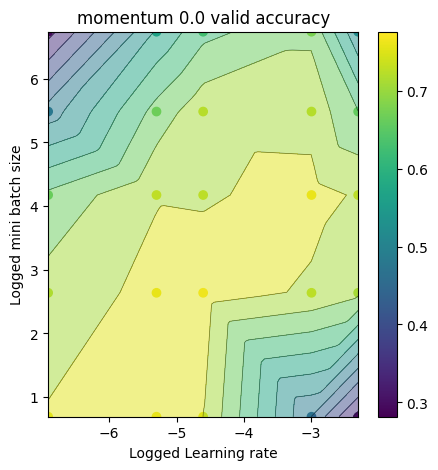

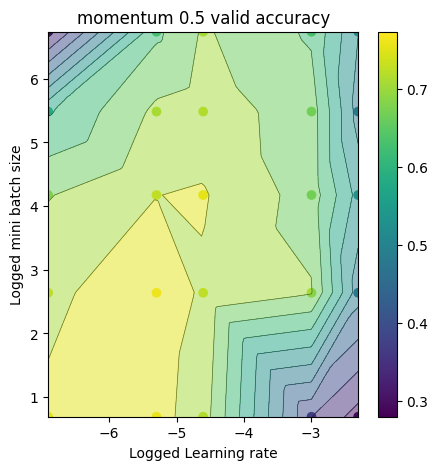

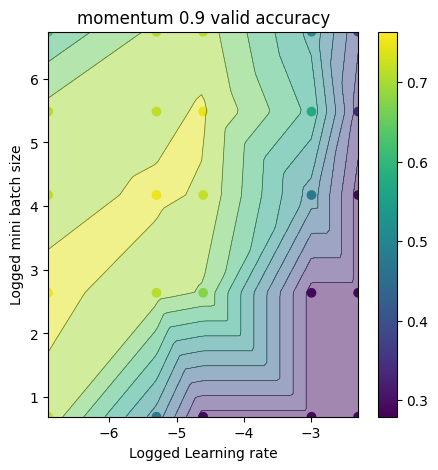

In [94]:
from typing import Callable
import matplotlib.tri as tri

def plot_results(x_values: Union[List[float], np.ndarray],
                 y_values: Union[List[float], np.ndarray],
                 z_values: Union[List[float], np.ndarray],
                 xlabel: str, 
                 ylabel: str,
                 title: str,
                 contour_levels: int = 14,
                 figsize: Tuple[int, int] = (10, 10)):
    """Plot experiment results
    
    Args:
        results: list of experiment results
        x_values: x list or array
        y_values: y list or array
        z_values: z list or array
        title: plot title
        xlabel: x axis label
        ylabel: y axis label
        contour_levels: number of contour levels
        figsize: figure size
    """
    
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.scatter(x_values, y_values, c=z_values, cmap='viridis')
    plt.colorbar()

    # create triangulation
    triang = tri.Triangulation(x_values, y_values)

    # interpolate data
    interpolator = tri.LinearTriInterpolator(triang, z_values)
    xi = np.linspace(min(x_values), max(x_values), 100)
    yi = np.linspace(min(y_values), max(y_values), 100)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)

    # plot contour
    plt.contour(xi, yi, zi, colors='k', levels=contour_levels, linewidths=0.5, alpha=0.5)
    plt.contourf(xi, yi, zi, levels=contour_levels, cmap='viridis', alpha=0.5)
    plt.show()

for m in momentum_candidates:
    x_values = np.log([r['lr'] for r in results if r['momentum'] == m])
    y_values = np.log([r['mini_batch_size'] for r in results if r['momentum'] == m])
    z_values = [r['valid_acc'] for r in results if r['momentum'] == m]

    plot_results(
        x_values=x_values,
        y_values=y_values,
        z_values=z_values,
        title=f'momentum {m} valid accuracy',
        xlabel='Logged Learning rate',
        ylabel='Logged mini batch size',
        contour_levels=10,
        figsize=(5, 5))

위 셀을 실행하면 다음과 같은 결과가 나옵니다.

![batch_lr_graph](./llr_lbs_m0_v_acc.png)
![batch_lr_graph](./llr_lbs_m5_v_acc.png)
![batch_lr_graph](./llr_lbs_m9_v_acc.png)

이 그래프를 보면 알 수 있듯이 learning rate와 mini-batch size는 서로 비례 관계에 있습니다. learning rate가 커지면 mini-batch size도 커져야 좋은 결과를 얻을 수 있습니다. 그리고 momentum은 batch size를 크게 해도 성능이 떨어지지 않게 해주는 것을 알 수 있습니다. 

65, 0.01, 0.5의 조합이 가장 최적으로 보입니다.

### 3. 신경망 모델 구조 변경: Momentum 을 0.9로 고정시킨 상태에서 신경망의 hidden unit 들의 갯수를 2 에서 100 사이의 3 가지 다른 경우에 대해 성능을 비교한다. 필요한 경우 learning rate 와 학습 기간(epochs)은 신경망 구조에 따라 적당하게 변경할 수 있다. Hidden unit 의 갯수들이 학습에서의 수렴과 신경망의 일반화 성는에 미치는 영향에 대한 데이터(표나 그래프)를 제시하고 경향을 분석하시오.

#### 실험 코드

In [ ]:
conf = Config(
    num_inputs=2304,
    num_hiddens=[16, 32],
    num_outputs=7,
    eps=0.01,
    momentum=0.9,
    num_epochs=1000,
    batch_size=241,
    early_stopping=True,
    patience=50,
)

num_hidden_candidates = [2, 4, 8, 16, 32, 64, 100]
hidden_candidates = itertools.product(num_hidden_candidates, num_hidden_candidates)

experiments_list = load_experiment_metafile('experiments_hidden.json',
        init_task_if_not_exists=hidden_candidates)

while len(experiments_list) > 0:
    num_hiddens = experiments_list["remain_experiments"].pop()

    print(f"Running experiment with {num_hiddens} hidden units")
    conf.num_hiddens = num_hiddens

    save_dir = f"results_hidden/{num_hiddens[0]}_{num_hiddens[1]}"
    _, stat, _ = ExperimentMLP(conf, title=f"hidden {num_hiddens}", show=False, 
        save_dir=save_dir)
    
    i, best_valid_acc = stat.best_valid_acc()
    experiments_list["completed_experiment_results"].append({
        "num_hiddens": num_hiddens,
        "save_dir": save_dir,
        "test_acc": stat.test_acc,
        "test_ce": stat.test_ce,
        "train_acc": stat.train_acc[i][1],
        "train_ce": stat.train_ce[i][1],
        "valid_acc": best_valid_acc,
        "valid_ce": stat.valid_ce[i][1],
        "time": stat.time
    })
    save_experiment_metafile('experiments_hidden.json', experiments_list)